### **If you choose to run this entire file, it will take ~20-25 minutes to complete due to the data being scraped.**

# Chapter 9. Getting Data

In [40]:
from __future__ import division
from collections import Counter
import math, random, csv, json
from bs4 import BeautifulSoup
import requests
import re

In order to be a data scientist you need data (yes, really).  
In this chapter, we take a look at different ways of getting data into Python and into the right formats.

## stdin and stdout

If you run your Python scripts at the command line, you can *pipe* data through them using <code>sys.stdin</code> and <code>sys.stdout</code>.  
For example, here is a script that reads in lines of text and spits back out the ones that match a regular expression:

Here's a program that counts the lines it receives and then writes out the count:

You could then use these to count how many lines of a file contain numbers.  
In Windows, you would use:  

<code>type SomeFile.txt | python egrep.py "[0-9]" | python line_count.py</code>  

whereas in a Unix system you would use:  

<code>cat SomeFile.txt | python egrep.py "[0-9]" | python line_count.py</code>  

The | is the pipe character, which means "use the output of the left command as the input of the right command".  
You can build some pretty elaborate data-processing pipelines this way.

Similarly, here is a script that counts the words in its input and writes out the most common ones:

In [41]:
cat lorem_ipsum.txt | python most_common_words.py 10

7	eget
7	in
6	non
5	sed
5	ut
4	vel
4	et
4	nulla
4	neque
4	ullamcorper


**Note**  
There are plenty of Unix command-line tools that can also be used, such as <code>grep</code> and <code>egrep</code>, that are probably preferable to building your own from scratch.

## Reading Files

### The Basics of Text Files

The first step in working with a text file is to obtain a *file object* using `open`:

In [42]:
# 'r' means read-only
file_for_reading = open('reading_file.txt', 'r')

# 'w' means write
#!# This will destroy the file if it already exists!
file_for_writing = open('writing_file.txt', 'w')

# 'a' means append
# for adding to the end of a file
file_for_appending = open('appending_file.txt', 'a')

#!# Don't forget to close your files when you're done!
file_for_reading.close()
file_for_writing.close()
file_for_appending.close()

Since it is easy to forget to close your files, you should always use them in a `with` block, at the end of which they will be closed automatically:

If you need to read a whole text file, you can just iterate over the lines of the file using `for`:

In [43]:
starts_with_hash = 0

with open('lorem_ipsum.txt', 'r') as f:
    for line in f:                 # look at each line in the file
        if re.match("^#",line):    # use a regex to see if it starts with '#'
            starts_with_hash += 1  # if it does, add 1 to the count

starts_with_hash

1

Every line you get this way ends in a newline character (\n), you you may want to `strip()` it before doing anything with it.

For example, imagine you have a file full of email addresses, one per line, and that you need to generate a histogram of the domains.  
A good first approximation is to just take the parts of the email addresses that come after the @.

In [44]:
def get_domain(email_address):
    """ split on '@' and return the last piece """
    return email_address.lower().split("@")[-1]

with open('email_addresses.txt', 'r') as f:
    domain_counts = Counter(get_domain(line.strip()) for line in f if "@" in line)

### Delimited Files

Frequently you will work with files that have lots of data on each line.  
These files are often either *comma-separated* or *tab-separated*.  
Don't try to parse them yourself -- use Python's `csv` module or the `pandas` library.  
If the file has no headers, you can use `csv.reader` to iterate over the rows.

For example, if we had a tab-delimited file of stock prices, we could process them with:

In [45]:
import csv

with open('tab_delimited_stock_prices.txt', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        date = row[0]
        symbol = row[1]
        closing_price = float(row[2])
        print(date, symbol, closing_price)

('6/20/2014', 'AAPL', 90.91)
('6/20/2014', 'MSFT', 41.68)
('6/20/2014', 'FB', 64.5)
('6/19/2014', 'AAPL', 91.86)
('6/19/2014', 'MSFT', 41.51)
('6/19/2014', 'FB', 64.34)


If your file has headers, you can either skip the header row (with an initial call to `reader.next()`), or get each row as a `dict`, with the headers as keys, by using `csv.DictReader`:

In [46]:
with open('colon_delimited_stock_prices.txt', 'r') as f:
    reader = csv.DictReader(f, delimiter=':')
    for row in reader:
        date = row["date"]
        symbol = row["symbol"]
        closing_price = float(row["closing_price"])
        print(date, symbol, closing_price)

('6/20/2014', 'AAPL', 90.91)
('6/20/2014', 'MSFT', 41.68)
('6/20/2014', 'FB', 64.5)


Even if your file doesn't have headers you can still use `DictReader` by passing it the keys as a `fieldnames` parameter.

You can similarly write out delimited data using `csv.writer`:

In [47]:
today_prices = { 'AAPL' : 95.95, 'MSFT' : 43.34, 'FB' : 66.66 }

with open('comma_delimited_stock_prices.txt', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    for stock, price in today_prices.items():
        writer.writerow([stock, price])

`csv.writer()` will do the right thing if your fields themselves have commas in them.  
Your own hand-rolled writer probably won't.  
For example, if you attempt: 

In [48]:
results = [["test1", "success", "Monday"],
           ["test2", "success, kind of", "Tuesday"],
           ["test3", "failure, kind of", "Wednesday"],
           ["test4", "failure, utter", "Thursday"]]

#!# don't do this!
with open('bad_csv.csv', 'w') as f:
    for row in results:
        f.write(",".join(map(str, row)))  # might have too many commas in it
        f.write("\n")                     # row might have newlines as well

You will end up with a `csv` file that looks like:

In [49]:
with open('bad_csv.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        print(row)

['test1', 'success', 'Monday']
['test2', 'success', ' kind of', 'Tuesday']
['test3', 'failure', ' kind of', 'Wednesday']
['test4', 'failure', ' utter', 'Thursday']


that will be very difficult to make sense of.  
Open the `bad_csv.csv` file in a text editor and see for yourself.

## Scraping the Web

### HTML and the Parsing Thereof

To get data out of HTML, we will use the [BeautifulSoup library](https://www.crummy.com/software/BeautifulSoup/), which builds a tree out of the various elements on a web page and provides a simple interface for accessing them.  
We will also be using the [requests library](http://docs.python-requests.org/en/latest/), which is a much nicer way of making HTTP requests than anything that's built into Python.  
Python's built-in HTML parser is not very lenient, meaning that it doesn't deal well with HTML that's not perfectly formed, so we will use [html5lib](https://github.com/html5lib/).

To use Beautiful Soup, we need to pass some HTML into the `BeautifulSoup()` function.  
In our examples, this will be the result of a call to `requests.get`:

In [50]:
from bs4 import BeautifulSoup
import requests
html = requests.get("http://www.example.com").text
soup = BeautifulSoup(html, 'html5lib')

after which we can get pretty far using a few simple methods.

We will typically work with `Tag` objects, which correspond to the tags representing the structure of an HTML page.  
For example, to find the first `<p>` tag (and its contents), you can use:

In [51]:
first_paragraph = soup.find('p')  # or just soup.p -- see below
first_paragraph

<p>This domain is established to be used for illustrative examples in documents. You may use this\n    domain in examples without prior coordination or asking for permission.</p>

In [52]:
also_first_paragraph = soup.p
also_first_paragraph

<p>This domain is established to be used for illustrative examples in documents. You may use this\n    domain in examples without prior coordination or asking for permission.</p>

You can get the text contents of a `Tag` using its `text` property:

In [53]:
first_paragraph_text = soup.p.text
first_paragraph_text

u'This domain is established to be used for illustrative examples in documents. You may use this\n    domain in examples without prior coordination or asking for permission.'

In [54]:
first_paragraph_words = soup.p.text.split()
first_paragraph_words

[u'This',
 u'domain',
 u'is',
 u'established',
 u'to',
 u'be',
 u'used',
 u'for',
 u'illustrative',
 u'examples',
 u'in',
 u'documents.',
 u'You',
 u'may',
 u'use',
 u'this',
 u'domain',
 u'in',
 u'examples',
 u'without',
 u'prior',
 u'coordination',
 u'or',
 u'asking',
 u'for',
 u'permission.']

You can extract a tag's attributes by treating it like a `dict`:

In [55]:
first_paragraph_id2 = soup.p.get('id')  # returns None if no 'id'
print(first_paragraph_id2)
first_paragraph_id2

None


You can get multiple tags at once:

In [56]:
all_paragraphs = soup.find_all('p')  # or just soup('p')
all_paragraphs

[<p>This domain is established to be used for illustrative examples in documents. You may use this\n    domain in examples without prior coordination or asking for permission.</p>,
 <p><a href="http://www.iana.org/domains/example">More information...</a></p>]

In [57]:
also_all_paragraphs = soup('p')
also_all_paragraphs

[<p>This domain is established to be used for illustrative examples in documents. You may use this\n    domain in examples without prior coordination or asking for permission.</p>,
 <p><a href="http://www.iana.org/domains/example">More information...</a></p>]

In [58]:
paragraphs_with_ids = [p for p in soup('p') if p.get('id')]
paragraphs_with_ids

[]

Frequently you will want to find tags with a specific `class`:

In [59]:
important_paragraphs = soup('p', {'class' : 'important'})
important_paragraphs

[]

In [60]:
important_paragraphs2 = soup('p', 'important')
important_paragraphs2

[]

In [61]:
important_paragraphs3 = [p for p in soup('p') if 'important' in p.get('class', [])]
important_paragraphs3

[]

You can combine methods to implement more elaborate logic.  
For example, if you want to find every `<span>` element that is contained in a `<div>` element, you could do this:

In [62]:
# Warning -- this will return the same span multiple times if it lies within multiple divs
# If that is the case, be more clever
span_inside_divs = [span 
                    for div in soup('div')    # for each <div> on the page, 
                    for span in div('span')]  # find each <span> inside of it.
span_inside_divs

[]

Good. Enough with the basics, let's look at an example.

### Example: O'Reilly Books About Data

A potential investor in DataSciencester thinks data is just a fad.  
To prove him wrong, you decide to examine how many data books O'Reilly has published over time.  
Whenever you want to scrape data, check to see if there is some sort of access policy like the one at `http://oreilly.com/terms/`.  
In order to be good citizens, we should also check for a `robots.txt` file that tells webcrawlers how to behave, which we can find at `http://shop.oreilly.com/robots.txt`.

`Crawl-delay: 30` tells us that we should wait 30 seconds between requests.  
`Request-rate: 1/30` tells us that we should only request one page every 30 seconds.  
The `Disallow` notifications tell us which directories *not* to scrape.

To figure out how to extract the data, let's download one of those pages and feed it to BeautifulSoup:

If you view the page source in your developer's tools, you will see that each book or video seems to be uniquely contained in a `<td>` table cell element with a `class` of `thumbtext` (`td.thumbtext`).

A good first step is to find all of the `td thumbtext` tag elements:

Next, we filter out the videos because the would-be investor is only impressed by books.  
If we inspect the HTML further, we can see that each `td` contains one or more `span` elements whose `class` is `pricelabel` and whose text looks like `Ebook:`, `Video:`, or `Print:`.  
It appears that the videos contain only one `pricelabel`, whose `text` begins with `Video` (after removing leading spaces).  
This means we can test for videos with:

Now we're ready to start pulling data out of the `td` elements.  
It looks like the book title is the text inside the `<a>` tag inside the `<div class="thumbheader">`:

The author(s) are in the text of the `AuthorName <div>`.  
They are prefaced by the word `By` (which we want to remove) and separated by commas (which we want to split out, after which we'll need to get rid of the spaces):

The ISBN seems to be contained in the link that's in the `thumbheader <div>`: 

And the date is just the contents of the `<span class="directorydate">`:

Now, let's put all of the above together into a function:

In [63]:
def book_info(td):
    """ given a BeautifulSoup <td> tag representing a book,
        extract the book's details and return a dict"""
    title = td.find("div", "thumbheader").a.text
    by_author = td.find('div', 'AuthorName').text
    authors = [x.strip() for x in re.sub("^By ", "", by_author).split(",")]
    isbn_link = td.find("div", "thumbheader").a.get("href")
    isbn = re.match("/product/(.*)\.do", isbn_link).groups()[0]
    date = td.find("span", "directorydate").text.strip()
    return {
        "title" : title,
        "authors" : authors,
        "isbn" : isbn,
        "date" : date
    }

Include the `is_video` function:

In [64]:
def is_video(td):
    """ it's a video if it has exactly one pricelabel and 
        if the stripped text inside that pricelabel begins with 'Video"""
    pricelabels = td('span', 'pricelabel')
    return (len(pricelabels) == 1 and pricelabels[0].text.strip().startswith("Video"))

And now, we're ready to scrape:

In [65]:
from bs4 import BeautifulSoup
import requests
from time import sleep  # to accommodate the 30 second pause between requests in the robots.txt file

base_url = "http://shop.oreilly.com/category/browse-subjects/data.do?sortby=publicationDate&page="
books = []
NUM_PAGES = 31  # at the time the book was written, probably more by now

for page_num in range(1, NUM_PAGES + 1):
    print "Souping page", page_num, ",", len(books), "found so far."
    url = base_url + str(page_num)
    soup = BeautifulSoup(requests.get(url).text, 'html5lib')
    for td in soup('td', 'thumbtext'):
        if not is_video(td):
            books.append(book_info(td))
    # now be a good citizen and respect the robots.txt
    sleep(30)

Souping page 1 , 0 found so far.
Souping page 2 , 21 found so far.
Souping page 3 , 46 found so far.
Souping page 4 , 73 found so far.
Souping page 5 , 96 found so far.
Souping page 6 , 117 found so far.
Souping page 7 , 139 found so far.
Souping page 8 , 164 found so far.
Souping page 9 , 189 found so far.
Souping page 10 , 211 found so far.
Souping page 11 , 237 found so far.
Souping page 12 , 258 found so far.
Souping page 13 , 279 found so far.
Souping page 14 , 306 found so far.
Souping page 15 , 332 found so far.
Souping page 16 , 358 found so far.
Souping page 17 , 381 found so far.
Souping page 18 , 406 found so far.
Souping page 19 , 429 found so far.
Souping page 20 , 451 found so far.
Souping page 21 , 479 found so far.
Souping page 22 , 505 found so far.
Souping page 23 , 531 found so far.
Souping page 24 , 557 found so far.
Souping page 25 , 586 found so far.
Souping page 26 , 614 found so far.
Souping page 27 , 642 found so far.
Souping page 28 , 667 found so far.
Souping

**NOTE**  
Extracting data from HTML like this is more data art than data science.  
There are many other find-the-books and find-the-titles recipes that would have worked just as well.

Now that you have collected the data, we can plot the numbers of books published each year:

In [66]:
def get_year(book):
    """ book["date] takes the format 'November 2014', so we need to split on the space and take the second piece """
    return int(book["date"].split()[1])

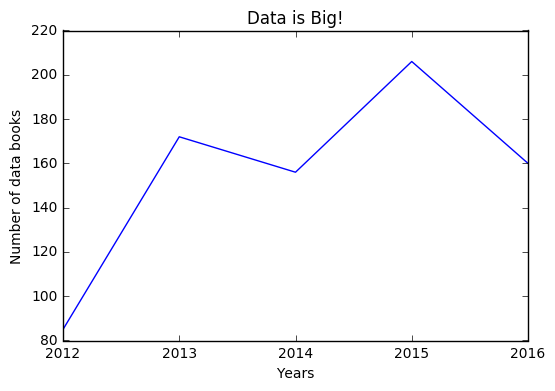

In [67]:
year_counts = Counter(get_year(book) for book in books
                      if get_year(book) <= 2016)

import matplotlib.pyplot as plt
years = sorted(year_counts)
book_counts = [year_counts[year] for year in years]
# https://docs.python.org/2/library/functions.html#enumerate
# plt.plot(years, book_counts) puts all data on the extreme right of the plot and 
# all years at the bottom of the y-axis
years_on_x = [i for i, _ in enumerate(years)]
plt.plot(years_on_x, book_counts)
# this next line is needed to display the years on the x-axis
plt.xticks([i for i, _ in enumerate(years)], years)
plt.xlabel("Years")
plt.ylabel("Number of data books")
plt.title("Data is Big!")
plt.show()

## Using APIs

Many websites and web services provide application programming interfaces (APIs) that allow the user to explicitly request data in a structured format.  
This saves the user (you) the trouble of having to scrape them!

### JSON and XML

HTTP is a protocol for transferring text, so the data you request through a web API needs to be [serialized](https://en.wikipedia.org/wiki/Serialization) into a string format.  
Often this serialization uses JavaScript Object Notation (JSON):

In [68]:
{ "title" : "Data Science Book",
  "author" : "Joel Grus",
  "publicationYear" : 2014,
  "topics" : [ "data", "science", "data science"] }

{'author': 'Joel Grus',
 'publicationYear': 2014,
 'title': 'Data Science Book',
 'topics': ['data', 'science', 'data science']}

We can parse JSON using Python's `json` module.  
In particular, we will use its `loads` function, which deserializes a string representing a JSON object into a Python object:

In [69]:
import json  

# enclose the JSON in triple quotes or you will get a TypeError: expected string or buffer
serialized = """{ "title" : "Data Science Book",
                  "author" : "Joel Grus",
                  "publicationYear" : 2014,
                  "topics" : [ "data", "science", "data science"] }"""

# parse the JSON to create a Python dict
deserialized = json.loads(serialized)
if "data science" in deserialized["topics"]:
    print deserialized

{u'publicationYear': 2014, u'author': u'Joel Grus', u'topics': [u'data', u'science', u'data science'], u'title': u'Data Science Book'}


Sometimes an API provider hates you and only provides responses in XML:

You can use `BeautifulSoup` to get data from XML in much the same way as we used it to get data from HTML.

### Using an Unauthenticated API

Most APIS these days require you to first authenticate yourself before using them.  
Let's take a look at [GitHub's API](https://developer.github.com/v3/), which allows you to do a few simple things without authentication:

In [70]:
import requests, json

endpoint = "https://api.github.com/users/bgroveben/repos"
repos = json.loads(requests.get(endpoint).text)
repos[0]

{u'archive_url': u'https://api.github.com/repos/bgroveben/angularOverview/{archive_format}{/ref}',
 u'assignees_url': u'https://api.github.com/repos/bgroveben/angularOverview/assignees{/user}',
 u'blobs_url': u'https://api.github.com/repos/bgroveben/angularOverview/git/blobs{/sha}',
 u'branches_url': u'https://api.github.com/repos/bgroveben/angularOverview/branches{/branch}',
 u'clone_url': u'https://github.com/bgroveben/angularOverview.git',
 u'collaborators_url': u'https://api.github.com/repos/bgroveben/angularOverview/collaborators{/collaborator}',
 u'comments_url': u'https://api.github.com/repos/bgroveben/angularOverview/comments{/number}',
 u'commits_url': u'https://api.github.com/repos/bgroveben/angularOverview/commits{/sha}',
 u'compare_url': u'https://api.github.com/repos/bgroveben/angularOverview/compare/{base}...{head}',
 u'contents_url': u'https://api.github.com/repos/bgroveben/angularOverview/contents/{+path}',
 u'contributors_url': u'https://api.github.com/repos/bgroveben/

At this point `repos` is a `list` of Python `dicts`, each representing a public repositiory on my GitHub account.  
We can use this data to figure out which months and days of the week I'm most likely to create a repository.

First, we need to deal with the the dates in the response, which are Unicode strings:  

u'created_at': u'2015-08-27T12:14:36Z'  

which can handled by installing `python-dateutil`.

In [71]:
from collections import Counter
from dateutil.parser import parse

dates = [parse(repo["created_at"]) for repo in repos]
month_counts = Counter(date.month for date in dates)
weekday_counts = Counter(date.weekday() for date in dates)

In [72]:
dates

[datetime.datetime(2015, 8, 27, 12, 14, 36, tzinfo=tzutc()),
 datetime.datetime(2016, 2, 8, 12, 25, 24, tzinfo=tzutc()),
 datetime.datetime(2015, 9, 10, 23, 57, 9, tzinfo=tzutc()),
 datetime.datetime(2013, 7, 25, 2, 18, 17, tzinfo=tzutc()),
 datetime.datetime(2013, 5, 23, 6, 58, 7, tzinfo=tzutc()),
 datetime.datetime(2013, 5, 21, 7, 16, 11, tzinfo=tzutc()),
 datetime.datetime(2015, 3, 19, 9, 28, 46, tzinfo=tzutc()),
 datetime.datetime(2016, 3, 19, 8, 26, 17, tzinfo=tzutc()),
 datetime.datetime(2016, 1, 15, 11, 19, 17, tzinfo=tzutc()),
 datetime.datetime(2016, 4, 20, 12, 22, 45, tzinfo=tzutc()),
 datetime.datetime(2015, 8, 6, 3, 42, 27, tzinfo=tzutc()),
 datetime.datetime(2014, 2, 26, 22, 23, 33, tzinfo=tzutc()),
 datetime.datetime(2016, 10, 5, 15, 11, 11, tzinfo=tzutc()),
 datetime.datetime(2016, 10, 31, 8, 35, 53, tzinfo=tzutc()),
 datetime.datetime(2014, 10, 10, 11, 34, 55, tzinfo=tzutc()),
 datetime.datetime(2016, 10, 19, 22, 15, 46, tzinfo=tzutc()),
 datetime.datetime(2014, 10, 10,

In [73]:
month_counts

Counter({1: 1,
         2: 3,
         3: 2,
         4: 2,
         5: 4,
         6: 3,
         7: 2,
         8: 3,
         9: 2,
         10: 5,
         11: 2,
         12: 1})

In [74]:
weekday_counts

Counter({0: 4, 1: 2, 2: 5, 3: 9, 4: 5, 5: 2, 6: 3})

Similarly, we can get the languages of my last five repositories:

In [75]:
last_5_repos = sorted(repos, key=lambda r: r["created_at"], reverse=True)[:5]
last_5_repos

[{u'archive_url': u'https://api.github.com/repos/bgroveben/coursera_python_fundamentals/{archive_format}{/ref}',
  u'assignees_url': u'https://api.github.com/repos/bgroveben/coursera_python_fundamentals/assignees{/user}',
  u'blobs_url': u'https://api.github.com/repos/bgroveben/coursera_python_fundamentals/git/blobs{/sha}',
  u'branches_url': u'https://api.github.com/repos/bgroveben/coursera_python_fundamentals/branches{/branch}',
  u'clone_url': u'https://github.com/bgroveben/coursera_python_fundamentals.git',
  u'collaborators_url': u'https://api.github.com/repos/bgroveben/coursera_python_fundamentals/collaborators{/collaborator}',
  u'comments_url': u'https://api.github.com/repos/bgroveben/coursera_python_fundamentals/comments{/number}',
  u'commits_url': u'https://api.github.com/repos/bgroveben/coursera_python_fundamentals/commits{/sha}',
  u'compare_url': u'https://api.github.com/repos/bgroveben/coursera_python_fundamentals/compare/{base}...{head}',
  u'contents_url': u'https://ap

In [76]:
last_5_languages = [repo["language"] for repo in last_5_repos]
last_5_languages

[u'Jupyter Notebook', u'Jupyter Notebook', u'Python', u'Python', u'HTML']

It is unusual to have to work with APIs at such a low level, like making the requests and parsing the responses ourselves.  
Someone else has (probably) already built a Python library for using pretty much any API you are interested in using.  
Still, you will occasionally have to roll your own API access library, debug someone else's, or have to figure out how to deal with a poorly written one, so it is good to know the details of how APIs work.

### Finding APIs

If you are looking for lists of APIs that have Python wrappers you can use [Python for Beginners](http://www.pythonforbeginners.com/development/list-of-python-apis/).  
A directory of web APIs that may or may not have Python wrappers can be found at [The Programmable Web](http://www.programmableweb.com/).
You can always resort to a Google search for 'python whatever API' or, as a last resort, you can always scrape your data.

## Example: Using the Twitter APIs

To interact with Twitter's APIs we'll be using the [Twython](https://github.com/ryanmcgrath/twython) library.

In [77]:
import json
from pprint import pprint
from twython import Twython

def search_twitter_for_data_science():
    """ search for tweets containing the phrase 'data science' """
    # put credentials in a separate file outside of version control and access them with json.load()
    with open('credentials.json') as json_data:
        credentials = json.load(json_data)
        consumer_key = credentials[0]["CONSUMER_KEY"]
        consumer_secret = credentials[0]["CONSUMER_SECRET"]
    
    # use Twython to make API calls
    twitter = Twython(consumer_key, consumer_secret)
    # search for tweets containing the phrase "data science"
    for status in twitter.search(q='"data science"')["statuses"]:
        # tweets often contain Unicode characters that print can't deal with, hence the .encode('utf-8')
        user = status["user"]["screen_name"].encode('utf-8')
        text = status["text"].encode('utf-8')
        # user's screen name and their respective tweets (with a line of whitespace between entries for readability)
        print user, ":", text
        print
        
search_twitter_for_data_science()

objetpetitm : @angadc but work even in better in data science. just throw in, casually, deep learning, stochastic model, bayesian inference. like voodoo.

HenryAkrofi : RT @KirkDBorne: Become a #DataScientist now.

Get a job, or your money back!

https://t.co/afNsbBvAn6 by @Springboard

#BigData #DataScienc…

Shiva_jai : RT @AnalyticsVidhya: #DataScience #Medium handles to follow: https://t.co/dik1iwNbDy @ageitgey @mrogati @SamDeBrule @olivercameron @NathanB…

jsunster : The 'fintech' approach to data science and machine learning https://t.co/uH8opTlJyU https://t.co/VGPMHnzBXx

htpotter : RT @HarvardBiz: Businesses are constantly generating enormous amounts of data but it doesn’t always translate to actionable info https://t.…

Worville : RT @pydatasci: The Python Data Science Handbook is now available! The entire book is also openly published as Jupyter notebooks: https://t.…

DataFest_ : RT @ImDataScientist: RT @edXOnline: The Importance of #DataScience in the 21st Century: https://t

Nice, but not terribly interesting, largely because the Twitter Search API just shows you whatever handful of recent results if feels like.  
When you're doing data science, more often you will want a *lot* of tweets.  
This is where the [Streaming API](https://dev.twitter.com/streaming/reference/get/statuses/sample) is useful.  
This is how you access a sample of the great Twitter firehose of data.
To use it, the user needs to authenticate using their access tokens.  
In order to access the Streaming API with Twython, we need to define a class that inherits from `TwythonStreamer` and that overrides its `on_success()` method and possibly its `on_error()` method as well.

In [78]:
from twython import TwythonStreamer

# appending data to a global variable is poor form, but it makes the example much simpler
tweets = []

class MyStreamer(TwythonStreamer):
    """ subclass of TwythonStreamer that specifies how to interact with the stream """
    
    def on_success(self, data):
        """ what to do when twitter sends us data -- a Python dict will represent a tweet """
        
        # only collect tweets that are in English
        if data['lang'] == 'en':
            tweets.append(data)
            print "received tweet #", len(tweets)
            
        # stop when we have collected enough
        if len(tweets) >= 1000:
            self.disconnect()
            
    def on_error(self, status_code, data):
        print status_code, data
        self.disconnect()

MyStreamer will connect to the Twitter stream and wait for Twitter to feed it data.  
Each time it receives some data (here, a Tweet represented as a Python object), it passes that object to the `on_success()` method, which appends it to our `tweets` list (if it is in English), and then disconnects the streamer after 1000 tweets have been collected.  
Got it? Good.  
Let's initialize this thing and get it running.

In [79]:
with open('credentials.json') as json_data:
    credentials = json.load(json_data)
    consumer_key = credentials[0]["CONSUMER_KEY"]
    consumer_secret = credentials[0]["CONSUMER_SECRET"]
    access_token = credentials[0]["ACCESS_TOKEN"]
    access_token_secret = credentials[0]["ACCESS_TOKEN_SECRET"]
    
stream = MyStreamer(consumer_key, consumer_secret, access_token, access_token_secret)
# start consuming public statuses that contain the keyword 'data'
stream.statuses.filter(track='data')
# if instead we want to start sampling *all* public statuses, use stream.statuses.sample()

received tweet # 1
received tweet # 2
received tweet # 3
received tweet # 4
received tweet # 5
received tweet # 6
received tweet # 7
received tweet # 8
received tweet # 9
received tweet # 10
received tweet # 11
received tweet # 12
received tweet # 13
received tweet # 14
received tweet # 15
received tweet # 16
received tweet # 17
received tweet # 18
received tweet # 19
received tweet # 20
received tweet # 21
received tweet # 22
received tweet # 23
received tweet # 24
received tweet # 25
received tweet # 26
received tweet # 27
received tweet # 28
received tweet # 29
received tweet # 30
received tweet # 31
received tweet # 32
received tweet # 33
received tweet # 34
received tweet # 35
received tweet # 36
received tweet # 37
received tweet # 38
received tweet # 39
received tweet # 40
received tweet # 41
received tweet # 42
received tweet # 43
received tweet # 44
received tweet # 45
received tweet # 46
received tweet # 47
received tweet # 48
received tweet # 49
received tweet # 50
received 

This will run until it collects 1000 tweets or throws an error, so go get some coffee and check your email.  
Once all that is finished, the user can start analyzing those tweets.  
For example, finding the most common hashtags:

In [80]:
from collections import Counter

top_hashtags = Counter(hashtag['text'].lower()
                       for tweet in tweets
                       for hashtag in tweet["entities"]["hashtags"])

print top_hashtags.most_common(5)

[(u'data', 47), (u'analytics', 35), (u'bigdata', 34), (u'obamalegacy', 12), (u'ogp16', 10)]


Each tweet contains a lot of data.  
Feel free to explore the data as well as the [Twitter API documentation](https://dev.twitter.com/overview/api/tweets).

## For Further Exploration
- [pandas](http://pandas.pydata.org/)
- [Scrapy](https://scrapy.org/) is a more full-featured library for building sophisticated web scrapers.